# Benchmark Data Visualization
This notebook compares EC and Replication benchmark results for `success_performance.med`, `success_performance.p(90)`, and `reqs.rate`.

For better visualization, it generates:
- One chart for each metric (med, p90, reqs.rate), comparing EC and Replication for each payload size and virtual user combination.
- Grouped comparisons by bandwidth, payload size, and virtual users to show performance scaling across different dimensions.

In [8]:
import json
import glob
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Path to your benchmark results directory
results_dir = './results/'
ec_pattern = results_dir + 'erasure/_system_*_*.json'
replication_pattern = results_dir + 'replication/_system_*_*.json'

# Helper to extract data from files

def extract_data(files, system_type):
    data = []
    for file in files:
        # Updated regex: matches kbit, mbit, gbit
        match = re.search(r'_system_(.+?)_(\d+)vu(?:_([0-9]+(?:kbit|mbit|gbit)))?\.json', file)
        if not match:
            continue
        payload_size = match.group(1)
        if payload_size.endswith('b'):
            payload_size = payload_size[:-1]
        try:
            payload_size = int(payload_size)
        except ValueError:
            pass
        virtual_user = match.group(2)
        bandwidth = match.group(3) if match.group(3) else 'unlimited'
        with open(file) as f:
            j = json.load(f)
            try:
                med = j['summary']['success_performance'].get('med', 0)
                p90 = j['summary']['success_performance'].get('p(90)', 0)
                avg = j['summary']['success_performance'].get('avg', 0)
            except (KeyError, TypeError):
                med = 0
                p90 = 0
                avg = 0
            try:
                rate = j['summary']['reqs'].get('rate', 0)
            except (KeyError, TypeError):
                rate = 0
            data.append({
                'system': system_type,
                'payload_size': payload_size,
                'virtual_user': int(virtual_user),
                'bandwidth': bandwidth,
                'med': med,
                'p90': p90,
                'avg': avg,
                'rate': rate
            })
    return data

# Collect EC and Replication data
files_ec = glob.glob(ec_pattern)
files_replication = glob.glob(replication_pattern)
data = extract_data(files_ec, 'EC') + extract_data(files_replication, 'Replication')
df = pd.DataFrame(data)
if not df.empty:
    # Sort by payload_size, virtual_user, bandwidth, then system for grouped comparison
    df = df.sort_values(['payload_size', 'virtual_user', 'bandwidth', 'system'])
    df['combo'] = df.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu_{row['bandwidth']}", axis=1)
    df.reset_index(drop=True, inplace=True)
df

,system,payload_size,virtual_user,bandwidth,med,p90,avg,rate,combo
0,EC,1024,1,10gbit,2.113236,2.564542,2.087227,442.585125,1024B_1vu_10gbit
1,Replication,1024,1,10gbit,0.595363,0.949784,0.735963,1143.444267,1024B_1vu_10gbit
2,EC,1024,1,10mbit,9.270221,10.369112,9.364797,104.616424,1024B_1vu_10mbit
3,Replication,1024,1,10mbit,11.257677,12.237910,11.335672,86.639145,1024B_1vu_10mbit
4,EC,1024,1,256kbit,300.401953,377.844858,319.174389,3.129966,1024B_1vu_256kbit
...,...,...,...,...,...,...,...,...,...
499,Replication,1000000,50,40mbit,39343.468332,39489.148788,34659.346927,1.069081,1000000B_50vu_40mbit
500,EC,1000000,50,55mbit,18542.581694,29503.029455,18083.000954,1.099955,1000000B_50vu_55mbit
501,Replication,1000000,50,55mbit,15657.961152,44507.907634,25591.985746,0.933294,1000000B_50vu_55mbit
502,EC,1000000,50,60mbit,24718.974372,31764.612365,22985.562127,1.733285,1000000B_50vu_60mbit


/tmp/ipykernel_1342341/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


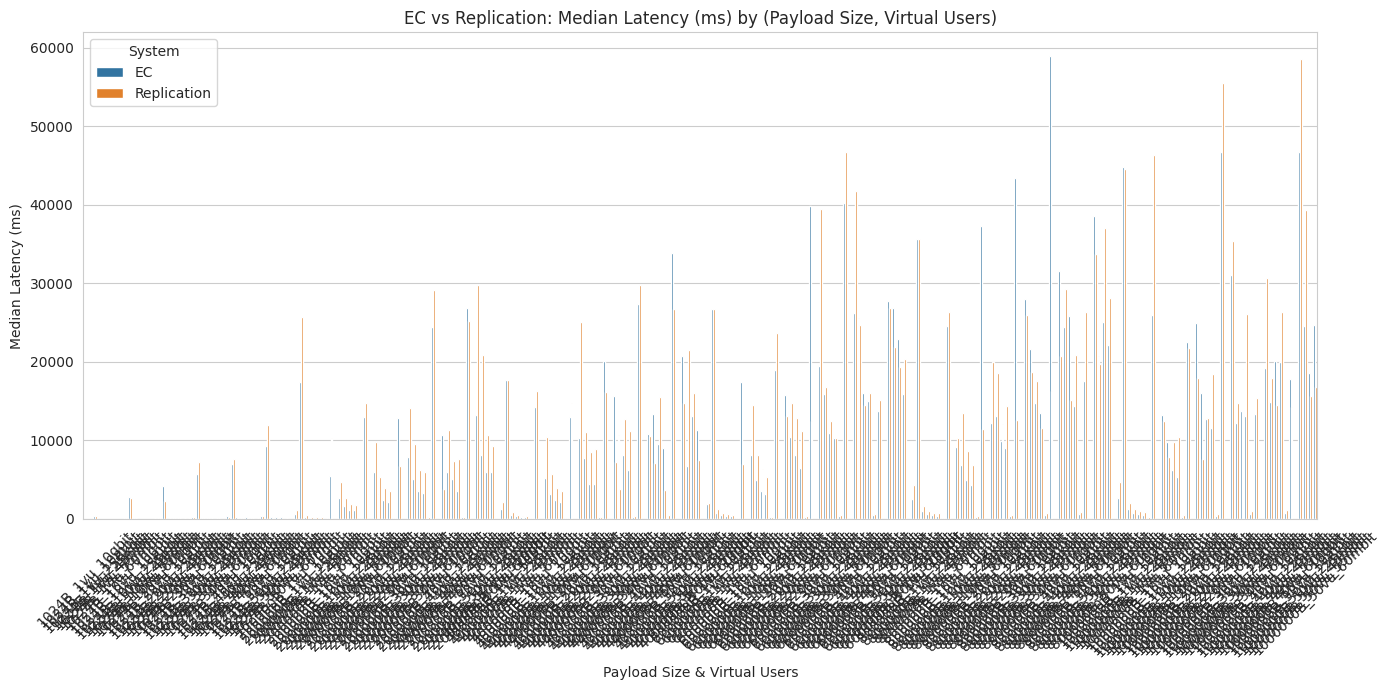

/tmp/ipykernel_1342341/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


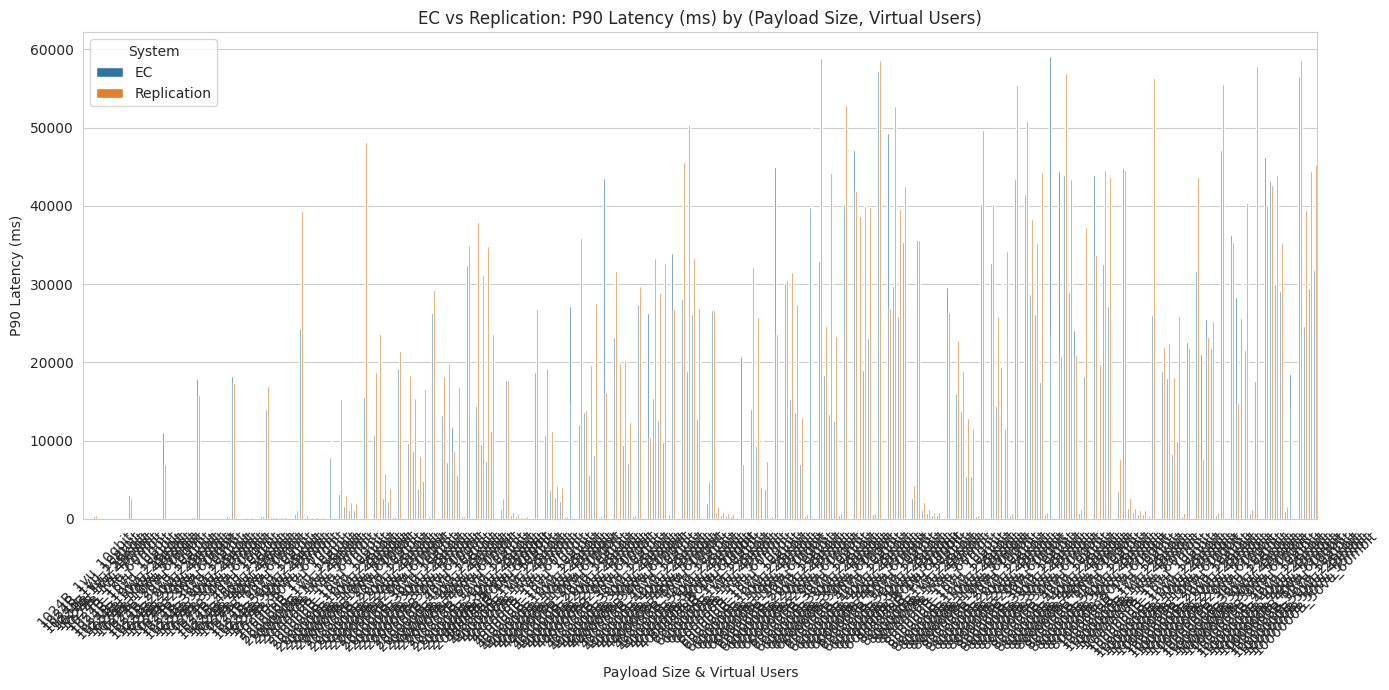

/tmp/ipykernel_1342341/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


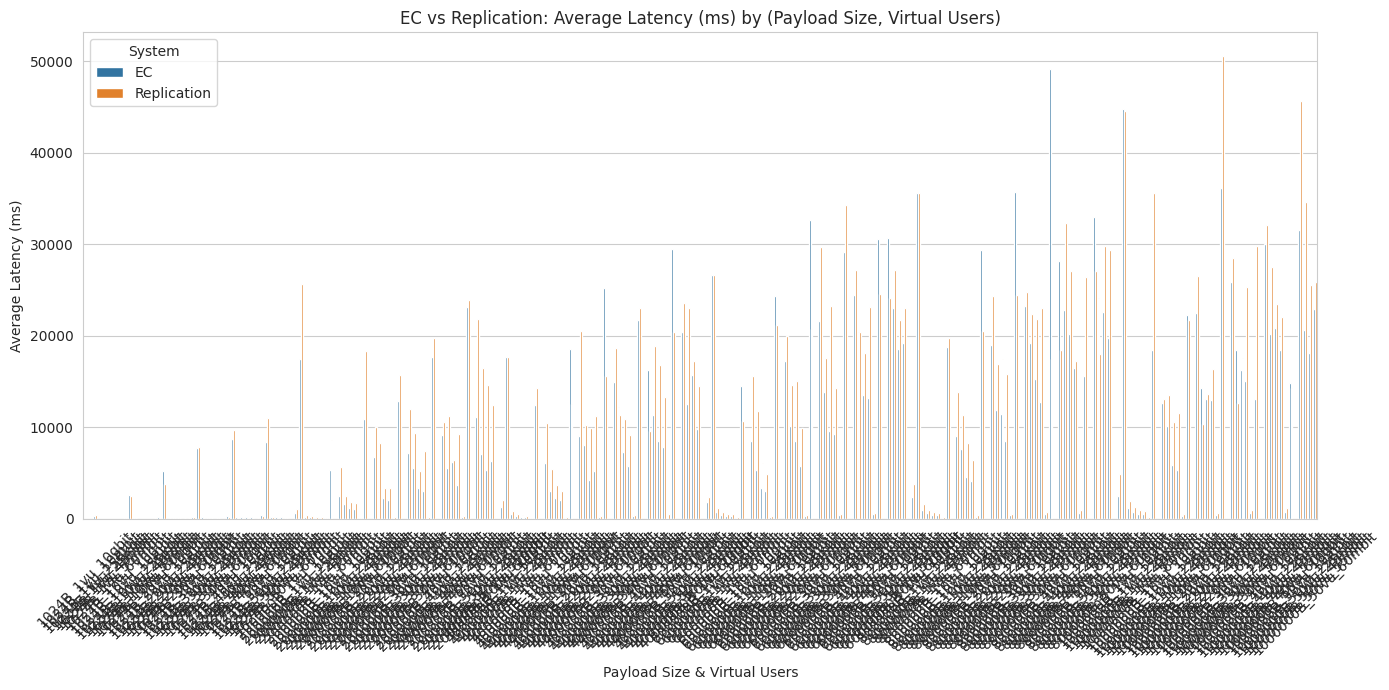

/tmp/ipykernel_1342341/2427503427.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


In [ ]:
# Plotting: Compare EC vs Replication for each metric, grouped by (payload_size, virtual_user)
sns.set_style("whitegrid")
metrics = ['med', 'p90', 'avg', 'rate']
metric_titles = {'med': 'Median Latency (ms)', 'p90': 'P90 Latency (ms)', 'avg': 'Average Latency (ms)', 'rate': 'Request Rate (req/s)'}

for metric in metrics:
    plt.figure(figsize=(14,7))
    sns.barplot(
        data=df,
        x='combo',
        y=metric,
        hue='system',
        ci=None,
        dodge=True
    )
    plt.title(f'EC vs Replication: {metric_titles[metric]} by (Payload Size, Virtual Users)')
    plt.xlabel('Payload Size & Virtual Users')
    plt.ylabel(metric_titles[metric])
    plt.xticks(rotation=45)
    plt.legend(title='System')
    plt.tight_layout()
    plt.show()

In [ ]:
# Create grouped visualizations for bandwidth, payload size, and virtual users

# First, let's check what distinct values we have for each parameter
print(f"Unique bandwidth values: {df['bandwidth'].unique()}")
print(f"Unique payload sizes: {df['payload_size'].unique()}")
print(f"Unique virtual users: {df['virtual_user'].unique()}")

In [ ]:
# 1. Grouping by bandwidth
# For each bandwidth, compare EC vs Replication across different payload sizes and virtual users
def plot_by_bandwidth(metric):
    bandwidths = df['bandwidth'].unique()
    for bw in bandwidths:
        # Filter data for this bandwidth
        df_bw = df[df['bandwidth'] == bw]
        
        if len(df_bw) > 0:
            plt.figure(figsize=(14, 7))
            # Create a new column for the x-axis that combines payload size and virtual users
            df_bw['payload_vu'] = df_bw.apply(lambda row: f"{row['payload_size']}B_{row['virtual_user']}vu", axis=1)
            
            # Plot
            sns.barplot(
                data=df_bw,
                x='payload_vu',
                y=metric,
                hue='system',
                ci=None,
                dodge=True
            )
            
            plt.title(f'EC vs Replication: {metric_titles[metric]} at {bw} Bandwidth')
            plt.xlabel('Payload Size & Virtual Users')
            plt.ylabel(metric_titles[metric])
            plt.xticks(rotation=45)
            plt.legend(title='System')
            plt.tight_layout()
            plt.show()

# Plot each metric grouped by bandwidth
for metric in metrics:
    plot_by_bandwidth(metric)

In [ ]:
# 2. Grouping by payload size
# For each payload size, compare EC vs Replication across different bandwidths and virtual users
def plot_by_payload(metric):
    payloads = df['payload_size'].unique()
    for payload in payloads:
        # Filter data for this payload size
        df_payload = df[df['payload_size'] == payload]
        
        if len(df_payload) > 0:
            plt.figure(figsize=(14, 7))
            # Create a new column for the x-axis that combines bandwidth and virtual users
            df_payload['bw_vu'] = df_payload.apply(lambda row: f"{row['bandwidth']}_{row['virtual_user']}vu", axis=1)
            
            # Plot
            sns.barplot(
                data=df_payload,
                x='bw_vu',
                y=metric,
                hue='system',
                ci=None,
                dodge=True
            )
            
            plt.title(f'EC vs Replication: {metric_titles[metric]} for {payload}B Payload Size')
            plt.xlabel('Bandwidth & Virtual Users')
            plt.ylabel(metric_titles[metric])
            plt.xticks(rotation=45)
            plt.legend(title='System')
            plt.tight_layout()
            plt.show()

# Plot each metric grouped by payload size
for metric in metrics:
    plot_by_payload(metric)

In [ ]:
# 3. Grouping by virtual users
# For each virtual user count, compare EC vs Replication across different bandwidths and payload sizes
def plot_by_vu(metric):
    vus = df['virtual_user'].unique()
    for vu in vus:
        # Filter data for this virtual user count
        df_vu = df[df['virtual_user'] == vu]
        
        if len(df_vu) > 0:
            plt.figure(figsize=(14, 7))
            # Create a new column for the x-axis that combines bandwidth and payload size
            df_vu['bw_payload'] = df_vu.apply(lambda row: f"{row['bandwidth']}_{row['payload_size']}B", axis=1)
            
            # Plot
            sns.barplot(
                data=df_vu,
                x='bw_payload',
                y=metric,
                hue='system',
                ci=None,
                dodge=True
            )
            
            plt.title(f'EC vs Replication: {metric_titles[metric]} with {vu} Virtual Users')
            plt.xlabel('Bandwidth & Payload Size')
            plt.ylabel(metric_titles[metric])
            plt.xticks(rotation=45)
            plt.legend(title='System')
            plt.tight_layout()
            plt.show()

# Plot each metric grouped by virtual users
for metric in metrics:
    plot_by_vu(metric)

In [ ]:
# 4. Create heatmaps to visualize the performance difference between EC and Replication
# This can help identify which configurations benefit most from EC vs Replication

def create_performance_diff_heatmap(metric):
    # Pivot the data to create a matrix of performance differences
    # First, create separate dataframes for EC and Replication
    df_ec = df[df['system'] == 'EC'].copy()
    df_repl = df[df['system'] == 'Replication'].copy()
    
    # Ensure we have matching rows in both dataframes
    common_conditions = pd.merge(
        df_ec[['payload_size', 'virtual_user', 'bandwidth']], 
        df_repl[['payload_size', 'virtual_user', 'bandwidth']],
        on=['payload_size', 'virtual_user', 'bandwidth'],
        how='inner'
    )
    
    if not common_conditions.empty:
        # Filter dataframes to include only common conditions
        df_ec_filtered = pd.merge(df_ec, common_conditions, on=['payload_size', 'virtual_user', 'bandwidth'])
        df_repl_filtered = pd.merge(df_repl, common_conditions, on=['payload_size', 'virtual_user', 'bandwidth'])
        
        # Calculate performance difference (EC - Replication)
        diff_data = []
        for _, ec_row in df_ec_filtered.iterrows():
            repl_row = df_repl_filtered[
                (df_repl_filtered['payload_size'] == ec_row['payload_size']) & 
                (df_repl_filtered['virtual_user'] == ec_row['virtual_user']) & 
                (df_repl_filtered['bandwidth'] == ec_row['bandwidth'])
            ].iloc[0]
            
            # For latency metrics (med, p90, avg), lower is better, so calculate as Replication - EC
            # For throughput (rate), higher is better, so calculate as EC - Replication
            if metric in ['med', 'p90', 'avg']:
                diff = repl_row[metric] - ec_row[metric]  # Positive means EC is better
            else:  # metric == 'rate'
                diff = ec_row[metric] - repl_row[metric]  # Positive means EC is better
                
            diff_data.append({
                'payload_size': ec_row['payload_size'],
                'virtual_user': ec_row['virtual_user'],
                'bandwidth': ec_row['bandwidth'],
                'diff': diff
            })
            
        diff_df = pd.DataFrame(diff_data)
        
        # Convert to pivot table for heatmap
        if len(diff_df['bandwidth'].unique()) > 1 and len(diff_df['payload_size'].unique()) > 1:
            # For each virtual user, create a heatmap of bandwidth vs payload size
            for vu in diff_df['virtual_user'].unique():
                vu_diff = diff_df[diff_df['virtual_user'] == vu]
                
                # Create pivot table
                pivot = vu_diff.pivot(index='bandwidth', columns='payload_size', values='diff')
                
                # Plot heatmap
                plt.figure(figsize=(12, 8))
                sns.heatmap(pivot, annot=True, cmap='RdBu_r', center=0, fmt='.2f')
                
                if metric in ['med', 'p90', 'avg']:
                    title_text = f'Performance Difference: Replication - EC {metric_titles[metric]} (Virtual Users: {vu})\nPositive (blue) means EC is better'
                else:  # metric == 'rate'
                    title_text = f'Performance Difference: EC - Replication {metric_titles[metric]} (Virtual Users: {vu})\nPositive (blue) means EC is better'
                    
                plt.title(title_text)
                plt.xlabel('Payload Size (bytes)')
                plt.ylabel('Bandwidth')
                plt.tight_layout()
                plt.show()

# Create heatmaps for each metric
for metric in metrics:
    create_performance_diff_heatmap(metric)